#### Estimation of Current in MOSFET using Machine Learning.-Ashish Verma[15MI423],Vivek Thakur[15MI424]


  
  * Use the `LinearRegressor` class in TensorFlow to predict current(Ids) based on one input feature
  * Evaluate the accuracy of a model's predictions using Root Mean Squared Error (RMSE)
  * Improve the accuracy of a model by tuning its hyperparameters

## Setup


In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10 #Not showing whole of dataset only first 10 rows
pd.options.display.float_format = '{:.1f}'.format

Next, we'll load our data set. The dataset is to uplode 
##Data is uploaded manually by right clicking on directory tree given on the left side of colab

In [0]:
MosDataframe = pd.read_csv("/content/mosfetCurrent.csv", sep=",")

We' randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent. Additionally, we'll scale `Current(Ids)` to be in units of thousands, so it can be learned a little more easily with learning rates in a range that we usually use.

In [23]:
MosDataframe = MosDataframe.reindex(
    np.random.permutation(MosDataframe.index))
MosDataframe["Ids"] /= 1000.0
MosDataframe

,Z(width of tx)[nm],L(Gate length-nm),e-mobility(u),Cox(Gate Cap),Tox,Eox,Na,Ni,T,Vfb,lamda,Vgs,Vds,Ids
6,76*10^(-9),15*10^(-9),960,70^(-9),9*10^(-9),3.7,9*10^15,1.60*10^10,306,31*10^(-3),0.1,3.6,1.8,0.0
19,89*10^(-9),28*10^(-9),1090,200^(-9),22*10^(-9),5.0,5.6*10^15,2.90*10^10,319,44*10^(-3),0.2,4.9,2.5,0.0
15,85*10^(-9),24*10^(-9),1050,160^(-9),18*10^(-9),4.6,5.1*10^15,2.50*10^10,315,40*10^(-3),0.2,4.5,1.5,0.0
22,92*10^(-9),31*10^(-9),1120,230^(-9),25*10^(-9),5.2,6*10^15,3.20*10^10,322,47*10^(-3),0.3,5.2,3.2,0.0
13,83*10^(-9),22*10^(-9),1030,140^(-9),16*10^(-9),4.4,4.7*10^15,2.30*10^10,313,38*10^(-3),0.2,4.3,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,93*10^(-9),32*10^(-9),1130,240^(-9),26*10^(-9),5.3,6.2*10^15,3.3.*10^10,323,48*10^(-3),0.3,5.3,3.2,0.0
14,84*10^(-9),23*10^(-9),1040,150^(-9),17*10^(-9),4.5,4.8*10^15,2.40*10^10,314,39*10^(-3),0.2,4.4,1.2,0.0
11,81*10^(-9),20*10^(-9),1110,120^(-9),14*10^(-9),4.2,4.5*10^15,2.10*10^10,311,36*10^(-3),0.2,4.1,0.5,0.0
5,75*10^(-9),14*10^(-9),950,60^(-9),8*10^(-9),3.6,8*10^15,1.50*10^10,305,30*10^(-3),0.1,3.5,1.5,0.0


In [24]:
MosDataframe.describe()

,e-mobility(u),Eox,T,lamda,Vgs,Vds,Ids
count,26.0,26.0,26.0,26.0,26.0,26.0,26.0
mean,1028.8,4.3,312.5,0.2,4.3,1.8,0.0
std,78.2,0.8,7.6,0.1,0.8,1.0,0.0
min,900.0,3.0,300.0,0.1,3.0,0.2,0.0
25%,962.5,3.7,306.2,0.1,3.6,1.0,0.0
50%,1035.0,4.3,312.5,0.2,4.2,1.8,0.0
75%,1097.5,5.0,318.8,0.2,4.9,2.5,0.0
max,1150.0,5.5,325.0,0.3,5.5,3.8,0.0


## Building the  Model

 we'll try to predict `Current(Ids)`, which will be our label . We'll use `Vds` as our input feature.



To train our model, we'll use the LinearRegressor  provided by the TensorFlow Estimator API. 

### Step 1: Define Features and Configure Feature Columns

In order to import our training data into TensorFlow, we need to specify what type of data each feature contains. 

 we indicate a feature's data type using a construct called a feature column. Feature columns store only a description of the feature data; they do not contain the feature data itself.
 we're going to use just one numeric input feature, `Vds`. The following code pulls the `Vds` data from our `MosDataframe` and defines the feature column using `numeric_column`, which specifies its data is numeric:

In [0]:
# Define the input feature: Vds.
my_feature = MosDataframe[["Vds"]]

# Configure a numeric feature column for Vds.
feature_columns = [tf.feature_column.numeric_column("Vds")]

Next, we'll define our target, which is `Current(Ids)`. Again, we can pull it from our `MosDataframe`:

In [0]:
# Define the label.
targets = MosDataframe["Ids"]

### Step 3: Configure the LinearRegressor

Next, we'll configure a linear regression model using LinearRegressor. We'll train this model using the `GradientDescentOptimizer`, which implements Mini-Batch Stochastic Gradient Descent (SGD). The `learning_rate` argument controls the size of the gradient step.


In [0]:
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

### Step 4: Define the Input Function

To import our  data into our `LinearRegressor`, we need to define an input function, which instructs TensorFlow how to preprocess
the data, as well as how to batch, shuffle, and repeat it during model training.

First, we convert our *pandas* feature data into a dict of NumPy arrays. We  use the TensorFlow to construct a dataset object from our data, and then break
our data into batches of `batch_size`, to be repeated for the specified number of epochs (num_epochs). 


Next, if `shuffle` is set to `True`, we'll shuffle the data so that it's passed to the model randomly during training. The `buffer_size` argument specifies
the size of the dataset from which `shuffle` will randomly sample.

Finally, our input function constructs an iterator for the dataset and returns the next batch of data to the LinearRegressor.

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):

  

  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) 
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Step 5: Training the Model

We can now call `train()` on our `linear_regressor` to train the model. We'll wrap `my_input_fn` in a `lambda`
so we can pass in `my_feature` and `targets` as arguments  and to start, we'll
train for 100 steps.

In [0]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

### Step 6: Evaluation of the Model(using RMSE)

In [30]:

prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 0.000
Root Mean Squared Error (on training data): 0.003


Mean Squared Error (MSE) can be hard to interpret, so we  look at Root Mean Squared Error (RMSE)
instead.  A nice property of RMSE is that it can be interpreted on the same scale as the original targets.

now we compare the RMSE to the difference of the min and max of our targets:

In [31]:
miminumCurrentVal = MosDataframe["Ids"].min()
maximumCurrentVal = MosDataframe["Ids"].max()
min_max_difference = maximumCurrentVal - miminumCurrentVal

print("Min. Median Current Value: %0.3f" % miminumCurrentVal)
print("Max. Median Current Value: %0.3f" % maximumCurrentVal)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 0.000
Max. Median House Value: 0.007
Difference between Min. and Max.: 0.007
Root Mean Squared Error: 0.003


In [32]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,26.0,26.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


### Taking definite values of Hyperparameters



Training model...
RMSE (on training data):
  period 00 : 0.00
  period 01 : 0.00
  period 02 : 0.00
  period 03 : 0.00
  period 04 : 0.00
  period 05 : 0.00
  period 06 : 0.00
  period 07 : 0.00
  period 08 : 0.00
  period 09 : 0.00
Model training finished.


,predictions,targets
count,26.0,26.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


Final RMSE (on training data): 0.00


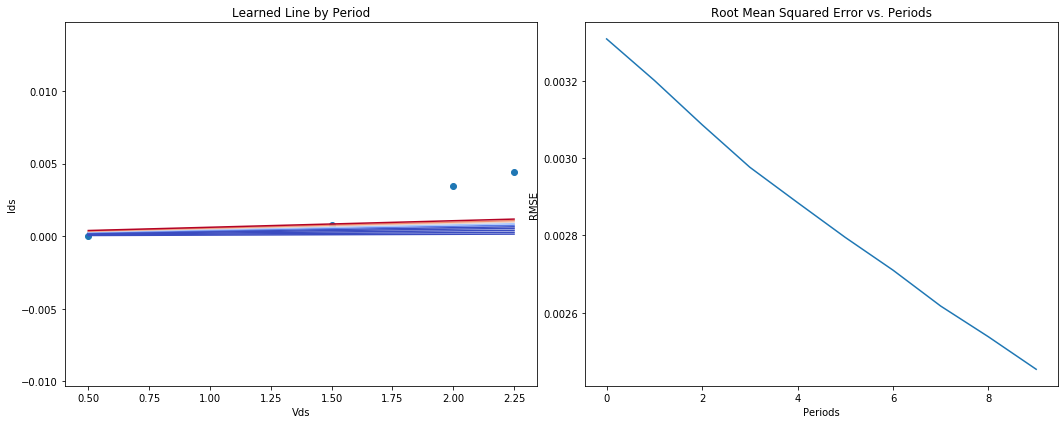

In [33]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

** Prediction of the current
use the predict function defined above

In [36]:
# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=4.5)#Value fed is the Vds(Drain Source Voltage)


Current Val in mili amps is 3.67
